In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
up = Path("..")
artefacts = up / up / up / "artefacts"

In [43]:
def mkdf(model: str) -> pd.DataFrame:
    # Load all metadata files
    files = (artefacts / "baselines" / model / "train").glob("apps_id_*/metadata.json")
    data = []
    for f in files:
        with open(f) as fp:
            metadata = json.load(fp)
            idx = f.parent.name.split("_")[-1]
            metadata["apps_id"] = idx
        data.append(metadata)
    
    df = pd.DataFrame(data).set_index("apps_id")
    
    # repair
    theorem_proven_cols = [col for col in df.columns if col.endswith('_proven') and col.startswith('theorem_')]
    df['theorems_proven'] = df[theorem_proven_cols].sum(axis=1)
    return df

def nonzero_solns(df: pd.DataFrame) -> pd.DataFrame:
    return df[df.theorems_proven > 0]

In [47]:
sonnet = mkdf("sonnet")
sonnet_wins = nonzero_solns(sonnet)

gemini = mkdf("gemini")
gemini_wins = nonzero_solns(gemini)

In [49]:
print(sonnet_wins.shape, gemini_wins.shape)

(43, 32) (23, 32)


# Quantitative visualization

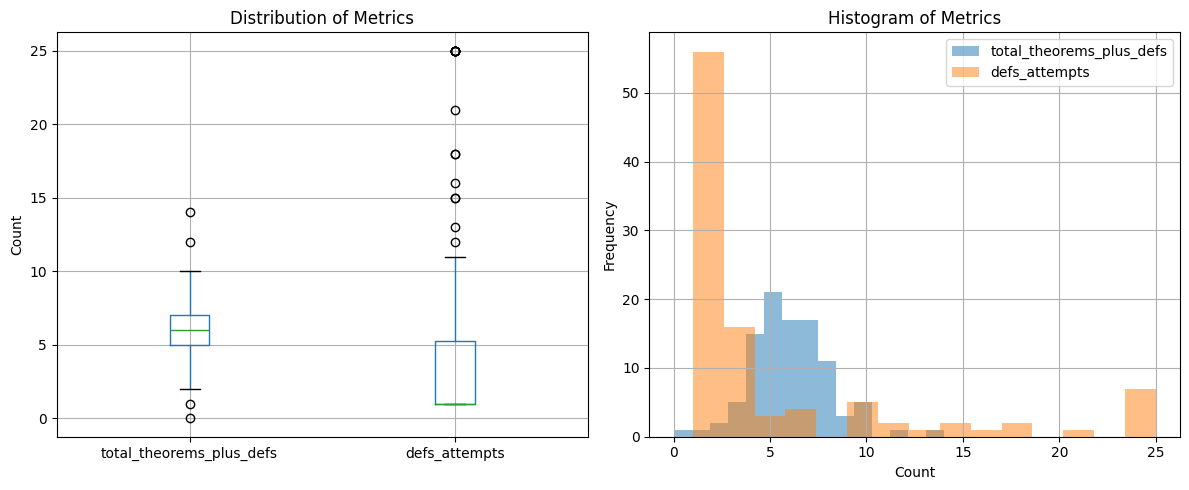

In [51]:
df = sonnet
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
columns = ['total_theorems_plus_defs', 'defs_attempts']
df[columns].boxplot(ax=ax1)
ax1.set_title('Distribution of Metrics')
ax1.set_ylabel('Count')

# Histograms
for col in columns:
    df[col].hist(alpha=0.5, bins=15, label=col, ax=ax2)
ax2.set_title('Histogram of Metrics')
ax2.set_xlabel('Count')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

<Axes: >

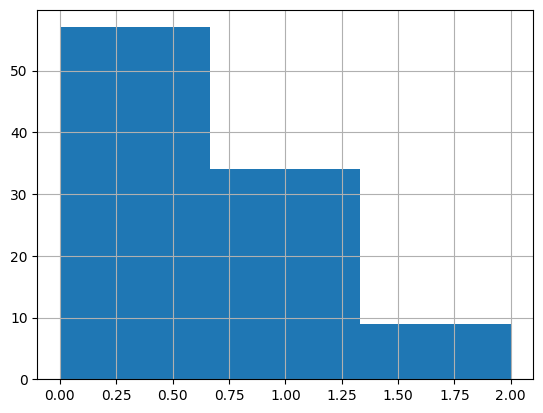

In [38]:
df["theorems_proven"].hist(bins=3, label="theorems_proven")

In [53]:
sonnet_wins.index

Index(['4742', '4430', '4172', '3819', '0282', '3877', '3057', '3040', '3402',
       '0314', '1804', '3192', '0375', '1265', '2667', '1850', '2459', '1710',
       '4412', '4017', '0930', '0323', '4036', '0077', '4802', '3199', '0666',
       '4045', '1306', '2342', '3078', '2649', '1233', '2109', '3430', '4002',
       '0069', '1732', '2052', '0669', '0267', '1318', '4350'],
      dtype='object', name='apps_id')

# Discussion of Samples with Solved Nonzero Theorems

- technically nonspurious but solved the easy case of an if: 0282, 3430
- substituted definition with effectively a unit test and really only proved one case: 1804, 2459, 1233
- `apply Nat.zero_le` loophole: 2459, 1233


# Specific Results (code samples)

## 0282

`Theorem_1_final.lean`:

```lean
/-- Calculate floor of sqrt of Int n using binary search -/
def floorSqrt (n: Int) : Int := Id.run do
  if n ≤ 0 then return 0
  let mut left := 1 
  let mut right := n
  let mut ans := 0
  while left ≤ right do
    let mid := left + (right - left) / 2
    if mid * mid ≤ n then
      ans := mid 
      left := mid + 1
    else
      right := mid - 1
  ans

/-- Get minimum element in list, returns 0 for empty list -/
def minElem (list: List Int) : Int :=
  match list with
  | [] => 0
  | x::xs => List.foldl min x xs

/-- Sum elements in list using foldl -/
def sumList (list: List Int) : Int :=
  List.foldl (· + ·) 0 list

/-- Alias for sumList -/
def listSum (list: List Int) : Int := sumList list

/-- Helper function to sum elements in square submatrix -/
def sumSquare (mat : List (List Int)) (i j size : Nat) : Int :=
  let square := List.take size $ List.drop i mat
  let rows := square.map (λ row => List.take size $ List.drop j row)
  sumList $ List.join rows

/-- Get the maximum side length of square submatrix with sum <= threshold -/
def maxSideLength (mat: List (List Int)) (threshold: Int) : Int := 
  match mat with
  | [] => 0
  | head::tail => 
    let m := tail.length + 1 -- rows
    let n := head.length -- cols
    if threshold < minElem (List.map minElem (head::tail)) then 0
    else
      -- Binary search implementation
      Id.run do
        let mut left := 1
        let mut right := min m n
        let mut ans := 0      
        while left ≤ right do
          let side := left + (right - left) / 2
          let mut found := false
          for i in [0:m - side + 1] do
            for j in [0:n - side + 1] do
              let mut squareSum := 0
              for r in [i:i+side] do
                squareSum := squareSum + (listSum $ List.take side $ List.drop j (mat[r]!))        
              if squareSum ≤ threshold then found := true
          if found then
            ans := side
            left := side + 1 
          else
            right := side - 1
        Int.ofNat ans

theorem minElem_cons_eq_minElem_map {x : List Int} {xs : List (List Int)} :
  minElem (List.map minElem (x::xs)) = minElem (minElem x :: List.map minElem xs) := by
  simp [List.map]

/-- If threshold is less than minimum element in matrix, max side length must be 0 -/
theorem maxSideLength_low_threshold {mat : List (List Int)} {threshold : Int}
  (h1 : ∀ row ∈ mat, row.length = (List.head! mat).length) 
  (h2 : threshold < minElem (List.map minEl em mat)) :
  maxSideLength mat threshold = 0 := by
  unfold maxSideLength
  cases mat with
  | nil => rfl 
  | cons head tail => 
    simp [minElem_cons_eq_minElem_map] at h2
    simp [h2]
```

### _discussion_

The theorem that succeeded was the easy case

## 3430

`Theorem_0_final.lean`:
```lean
def lowest_temp (s : String) : Option Int := 
  -- If string is empty, return none
  if s.isEmpty then none
  else
    -- Split string by spaces and convert to array of ints
    let temps := s.split (· = ' ') |>.toArray
    if temps.isEmpty then none 
    else
      -- Start with first number as minimum
      let first := temps[0]!.toInt!
      -- Fold over remaining numbers to find minimum 
      some (temps.foldl (init := first) fun acc str =>  
        let curr := str.toInt!
        if curr < acc then curr else acc)

theorem lowest_temp_empty: lowest_temp "" = none := by
  -- Unfold definition of lowest_temp 
  unfold lowest_temp
  -- Since "" is empty, the isEmpty check returns true
  simp [String.isEmpty]
  -- For empty string, need to show endPos ≠ 0 implies split returns []
  intro h
  -- Empty string has endPos = utf8ByteSize = 0
  have : "".utf8ByteSize = 0 := rfl
  -- This contradicts our assumption h
  contradiction
```

### _discussion_

Same as above- the theorem that succeeded was the trivial case.